In [ ]:
workspace_name = 'livedemo1'

In [ ]:
!pwd

/notebooks


In [2]:
%cd /content/drive/MyDrive/London/cci/realtime-flask-model

/content/drive/MyDrive/London/cci/realtime-flask-model


### Install Pakages

In [ ]:
!mkdir {workspace_name}

mkdir: cannot create directory ‘livedemo1’: File exists


In [ ]:
%cd /notebooks/rewriting-activation-maps/

/notebooks/rewriting-activation-maps


In [3]:
%%writefile requirements.txt
bidict==0.22.0
click==8.1.3
Flask==2.2.0
Flask-SocketIO==5.2.0
h11==0.13.0
importlib-metadata==4.12.0
itsdangerous==2.1.2
Jinja2==3.1.2
MarkupSafe==2.1.1
python-engineio==4.3.3
python-socketio==5.7.1
typing_extensions==4.3.0
Werkzeug==2.2.1
wsproto==1.1.0
zipp==3.8.1
pyngrok==5.1.0

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.4/232.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.3/745.3 kB 20.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.1

### Setup Workspace

In [ ]:
%cd /notebooks/{workspace_name}

/notebooks/livedemo1


In [4]:
!mkdir templates
!mkdir static
!mkdir static/js

In [5]:
%%writefile static/js/main.js 
$(document).ready(function () {
  const FRAME_SIZE = 256
  const FRAME_RATE = 100 //ms per frame
  let namespace = "/test";
  let video = document.querySelector("#videoElement");
  let canvas = document.querySelector("#canvasElement");
  canvas.width = FRAME_SIZE;
  canvas.height = FRAME_SIZE;
  let ctx = canvas.getContext('2d');
  ctx.translate(FRAME_SIZE,1);
  ctx.scale(-1,1);
  crop_factor = 0.5;
  photo = document.getElementById('photo');
  var localMediaStream = null;

  var socket = io.connect(location.protocol + '//' + document.domain + ':' + location.port + namespace);

  function sendSnapshot() {

    if (!localMediaStream) {
      return;
    }

    // ctx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight,0,0,FRAME_SIZE,FRAME_SIZE);
    ctx.drawImage(video, 
                  crop_factor/2*video.videoWidth, 
                  crop_factor/2*video.videoHeight, 
                  (1-crop_factor/2)*video.videoWidth, 
                  (1-crop_factor/2)*video.videoHeight,
                  0,0,FRAME_SIZE,FRAME_SIZE);
    let dataURL = canvas.toDataURL('image/jpeg',0.7);
    socket.emit('image_in', dataURL);

  }

  socket.on('connect', function() {
    console.log('Connected!');
  });

  var constraints = {
    audio: false,
    video: {
      width: FRAME_SIZE,
      height: FRAME_SIZE,
    }
  };

  navigator.mediaDevices.getUserMedia(constraints).then(function(stream) {
    video.srcObject = stream;
    localMediaStream = stream;

    setInterval(function () {
      sendSnapshot();
    }, FRAME_RATE);

    socket.on('image_back',function(data){
      photo.setAttribute('src', data.image_data);
    });

  }).catch(function(error) {
    console.log(error);
  });
});

Writing static/js/main.js


In [6]:
%%writefile templates/index.html
<!DOCTYPE html>
<html>
    <head>
      <meta charset="utf-8">
      <title>Live</title>
      <style>
        #container {
        }
        #videoElement {
        display: none;
        }
        #canvasElement {
        width: 512px;
        height: 512px;
        border: 1px solid black;
        }
        #photo {
        width: 512px;
        height: 512px;
        border: 1px solid black;
        }
      </style>
    </head>
    <body>
      <div id="container">
        <div>
          <video autoplay="true" id="videoElement"></video>
          <canvas id="canvasElement"></canvas>

          <img id="photo">
        </div>
      </div>

      <script src="https://code.jquery.com/jquery-3.2.1.slim.min.js" integrity="sha256-k2WSCIexGzOj3Euiig+TlR8gA0EmPjuc79OEeY5L45g=" crossorigin="anonymous"></script>
      <script src="https://cdn.socket.io/4.5.0/socket.io.min.js" integrity="sha384-7EyYLQZgWBi67fBtVxw60/OWl1kjsfrPFcaU0pp0nAh+i8FD068QogUvg85Ewy1k" crossorigin="anonymous"></script>
      <script src="{{ url_for('static', filename='js/main.js') }}"></script>
    </body>
</html>

Writing templates/index.html


In [7]:
%%writefile utils.py

from PIL import Image
from io import BytesIO
import base64

def pil_image_to_base64(pil_image, quality = 75):
    buf = BytesIO()
    pil_image.save(buf, format="JPEG", quality= quality)
    return base64.b64encode(buf.getvalue())


def base64_to_pil_image(base64_img):
    return Image.open(BytesIO(base64.b64decode(base64_img)))

Writing utils.py


In [8]:
%%writefile processor.py

from PIL import Image
import threading
from time import sleep
from utils import base64_to_pil_image, pil_image_to_base64

class Processor(object):
    def __init__(self, model_backend):
        self.to_process = []
        self.to_output = []
        self.model_backend = model_backend

        thread = threading.Thread(target=self.keep_processing, args=())
        thread.daemon = True
        thread.start()

    def process_one(self):
        if not self.to_process:
            return

        # input is an ascii string. 
        input_str = self.to_process.pop(0)

        # convert it to a pil image
        input_img = base64_to_pil_image(input_str)

        ################## where the hard work is done ############
        # output_img is an PIL image
        output_img = self.model_backend.generate(input_img,resize=1024)

        # output_str is a base64 string in ascii
        output_str = pil_image_to_base64(output_img, quality = 60)

        # convert eh base64 string in ascii to base64 string in _bytes_
        self.to_output.append(output_str)

    def keep_processing(self):
        while True:
            self.process_one()
            sleep(0.01)

    def enqueue_input(self, input):
        self.to_process.append(input)

    def get_frame(self):
        while not self.to_output:
            sleep(0.05)
        return self.to_output.pop(0)

class MyModel(object):
    def __init__(self):
        pass

    def generate(self, img):
        return img.transpose(Image.FLIP_LEFT_RIGHT)

Writing processor.py


In [9]:
%%writefile app.py

from sys import stdout
# from makeup_artist import Makeup_artist
import logging

from flask import Flask, render_template, Response
from flask_socketio import SocketIO, emit

# from threading import Lock
import os
from processor import Processor
from processor import MyModel
from utils import base64_to_pil_image, pil_image_to_base64
from base64 import b64encode

log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)

async_mode = None
app = Flask(__name__)
app.logger.addHandler(logging.StreamHandler(stdout))
app.config['SECRET_KEY'] = os.urandom(24).hex()
app.config['DEBUG'] = True
socketio = SocketIO(app)
processor = Processor(MyModel())

@app.route('/')
def index():
    """Video streaming home page."""
    return render_template('index.html')


@socketio.on('image_in', namespace='/test')
def test_message(input):
    input = input.split(",")[1]
    processor.enqueue_input(input)
    #########
    image_data = "data:image/jpeg;base64," + str(processor.get_frame(), "utf-8")
    emit('image_back', {'image_data': image_data}, namespace='/test')


@socketio.on('connect', namespace='/test')
def test_connect():
    app.logger.info("client connected")

if __name__ == '__main__':
    socketio.run(app,port=80)

Writing app.py


### Run APP (Command Line)

In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token('2CWiS6qXbQLqjVbtCMZkY7hNlgo_7srpDii96j6fi5HLVfPj1')

In [ ]:
%cd /content/{workspace_name}

/content/livedemo1


In [ ]:
!python app.py

WebSocket transport not available. Install simple-websocket for improved performance.
 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:80 (Press CTRL+C to quit)
 * Restarting with stat
WebSocket transport not available. Install simple-websocket for improved performance.
 * Debugger is active!
 * Debugger PIN: 142-196-776


In [ ]:
public_url = ngrok.connect(bind_tls=True)
public_url

In [ ]:
ngrok.kill()

### Run APP (Notebook Cell)

In [ ]:
%cd /notebooks/rewriting-activation-maps/

/notebooks/livedemo1


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token('2CWiS6qXbQLqjVbtCMZkY7hNlgo_7srpDii96j6fi5HLVfPj1')

In [ ]:
from sys import stdout
# from makeup_artist import Makeup_artist
import logging

from flask import Flask, render_template, Response
from flask_socketio import SocketIO, emit

# from threading import Lock
import os
from processor import Processor
from processor import MyModel
from utils import base64_to_pil_image, pil_image_to_base64
from base64 import b64encode

In [ ]:
import logging
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)

In [ ]:
async_mode = None
app = Flask('app')
app.logger.addHandler(logging.StreamHandler(stdout))
app.config['SECRET_KEY'] = os.urandom(24).hex()
app.config['DEBUG'] = False
socketio = SocketIO(app)
processor = Processor(appended_network)

@app.route('/')
def index():
    """Video streaming home page."""
    return render_template('index.html')


@socketio.on('image_in', namespace='/test')
def test_message(input):
    input = input.split(",")[1]
    processor.enqueue_input(input)
    #########
    image_data = "data:image/jpeg;base64," + str(processor.get_frame(), "utf-8")
    emit('image_back', {'image_data': image_data}, namespace='/test')


@socketio.on('connect', namespace='/test')
def test_connect():
    app.logger.info("client connected")


In [ ]:
socketio.run(app,port=80,log_output=True)

 * Serving Flask app 'app'
 * Debug mode: off


The WebSocket transport is not available, you must install a WebSocket server that is compatible with your async mode to enable it. See the documentation for details. (further occurrences of this error will be logged with level INFO)


In [ ]:
public_url = ngrok.connect(bind_tls=True)
public_url

<NgrokTunnel: "https://1218-172-83-13-4.ngrok.io" -> "http://localhost:80">

In [ ]:
ngrok.kill()

### install backend

In [ ]:
!pip install timm
!pip install ftfy
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 20.8 MB/s eta 0:00:00


In [ ]:
%cd /notebooks/livedemo1/

/notebooks/livedemo1


In [ ]:
!git clone https://github.com/NVlabs/stylegan3

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 8.04 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
%cd /notebooks/livedemo1/stylegan3


/notebooks/livedemo1/stylegan3


In [ ]:
!gdown 18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj

Downloading...
From: https://drive.google.com/uc?id=18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj
To: /content/livedemo1/stylegan3/wikiart-1024-stylegan3-t-17.2Mimg.pkl
100% 295M/295M [00:05<00:00, 56.5MB/s]


In [ ]:
!gdown 12vW190Amwy0WZKtEl9_saQtrirKJu2Pb

Downloading...
From: https://drive.google.com/uc?id=12vW190Amwy0WZKtEl9_saQtrirKJu2Pb
To: /notebooks/livedemo1/stylegan3/vae_256_ws.p
100%|████████████████████████████████████████| 618M/618M [00:28<00:00, 21.9MB/s]


### setup backend

In [ ]:
%cd /notebooks/stylegan3


/notebooks/stylegan3


In [ ]:
import os
import re
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt

import click
import dnnlib
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
# from kornia.morphology import erosion

import legacy
# from torch_utils import gen_utils

from torch_utils import misc
# from torch_utils.ops import conv2d_gradfix
from torch_utils.ops import filtered_lrelu
from torch_utils.ops import bias_act
from torch_utils import persistence

#### wikiart_5

In [ ]:
# @persistence.persistent_class
class AppendedEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_clamp = 256
    self.device = torch.device('cuda')
    # self.ero_kernal_5 = torch.ones(5,5).to(device)

    # self.L14_1024_3_w = torch.nn.Parameter(torch.randn([64, 3, 1, 1]))
    self.L_256_1 = torch.nn.Sequential(
      # input is 1,3,160,160
      torch.nn.Conv2d(1, 1024, 3, stride=2, padding=1, bias=True), # in_channels, out_channels, kernel_size, stride=1, padding=0
      torch.nn.LeakyReLU(0.2, inplace=True),
      # transforms.GaussianBlur(7, sigma=(7))
    )
    self.L_256_2 = torch.nn.Sequential(
      # 1,256,80,80
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.BatchNorm2d(1024),
      # transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_256_3 = torch.nn.Sequential(
      # 1,1024,40,40
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.BatchNorm2d(1024)
      # transforms.GaussianBlur(3, sigma=(3))
    )
    self.L_256_4 = torch.nn.Sequential(
      # 1,1024,20,20
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.BatchNorm2d(1024)
      # transforms.GaussianBlur(3, sigma=(3))
      # 1,1024,20,20
    )
    self.L_256_5 = torch.nn.Sequential(
      # 1,1024,10,10
      torch.nn.Conv2d(1024, 1024, 3, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # 1,1024,10,10
    )
    self.L_transit = torch.nn.Sequential(
      # 1,1024,10,10
      torch.nn.Conv2d(1024, 1024, 3, padding=1, bias=True),
      # transforms.GaussianBlur(3, sigma=(3)),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, stride=1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True)
      # 1,1024,10,10
    )

    self.L_128_0 = torch.nn.Sequential(
      # input is 1,1024,10,10
      torch.nn.BatchNorm2d(1024),
      torch.nn.Conv2d(1024, 1024, 3, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(3, sigma=(3))
      # 1,1024,21,21
    )

    self.L_128_1 = torch.nn.Sequential(
      # input is 1,1024,20,20
      torch.nn.BatchNorm2d(1024),
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_128_2 = torch.nn.Sequential(
      # 1,1024,40,40
      torch.nn.BatchNorm2d(1024),
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_128_3 = torch.nn.Sequential(
      # 1,1024,80,80
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_128_4 = torch.nn.Sequential(
      # 1,1024,80,80
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True)
      # torch.nn.Upsample(scale_factor=2), 
      # transforms.GaussianBlur(3, sigma=(3))
    )
    self.L_128_out = torch.nn.Sequential(
      # 1,1024,80,80
      torch.nn.Conv2d(1024, 512, 1, padding=0, bias=False),
      # transforms.GaussianBlur(3, sigma=(3))
    )

    # self.out_layer = torch.nn.Conv2d(1024,1024,1,bias=True)
    # self.out_b = torch.nn.Parameter(torch.zeros([1024]))


    

  def forward(self, x):
    dtype = torch.float32

    x = torch.mean(x.to(dtype), dim = 1, keepdim=True)

    # x = transforms.functional.gaussian_blur(x.to(dtype),kernel_size=7,sigma=(7))
    # x = transforms.functional.gaussian_blur(x,kernel_size=5,sigma=(5))
    # x = transforms.functional.gaussian_blur(x,kernel_size=5,sigma=(5))

    x = self.L_256_1(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_256_2(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_256_3(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_256_4(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_256_5(x)

    x = self.L_transit(x)
    
    # x = torch.nn.functional.interpolate(x, scale_factor=0.5)
    x = self.L_128_0(x)

    x = self.L_128_1(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_128_2(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_128_3(x)
    # x = erosion(x, self.ero_kernal_5)
    x = self.L_128_4(x)
    # x = erosion(x, self.ero_kernal_3)
    x = self.L_128_out(x)


    # # 3, 1024, 1024
    # x = torch.nn.functional.interpolate(x, scale_factor=0.5)
    # x = transforms.functional.gaussian_blur(x,kernel_size=11,sigma=(10))

    # x = self.L15_1024_3_64(x.to(dtype))
    # x = transforms.functional.gaussian_blur(x,kernel_size=11,sigma=(10))
    # # x = transforms.functional.gaussian_blur(x,kernel_size=5,sigma=(10))
    # x = torch.nn.functional.leaky_relu(x)
    # # 64, 1024, 1024

    
    return x




In [ ]:
class Assembled(object):

    def __init__(self, g_path, ap_path, test_path = None):

      self.device = torch.device('cuda')
      with dnnlib.util.open_url(network_pkl) as f:
        g_model = legacy.load_network_pkl(f)['G_ema'].eval().requires_grad_(False)
        self.g = g_model.synthesis.to(self.device)
        self.m = g_model.mapping.to(self.device)

      self.ap = torch.load(ap_path)
      self.convert_tensor = transforms.ToTensor()
      self.init_ws = self.get_ws()


    def rewrite(self, y_in, ws, scaled = True, resize = 512):

      x = torch.nn.functional.interpolate(y_in, size=(84,84))

      x = self.g.L5_148_512(x,ws[5])
      x = self.g.L6_148_512(x,ws[7])
      x = self.g.L7_276_323(x,ws[8])
      x = self.g.L8_276_203(x,ws[9])
      x = self.g.L9_532_128(x,ws[10])
      x = self.g.L10_1044_81(x,ws[11])
      x = self.g.L11_1044_51(x,ws[12])
      x = self.g.L12_1044_32(x,ws[13])
      x = self.g.L13_1024_32(x,ws[14])
      if scaled:
        l_15 = self.g.L14_1024_3(x,ws[15])*self.g.output_scale
        l_15 = torch.nn.functional.interpolate(l_15, size=(resize,resize))
      else:
        l_15 = self.g.L14_1024_3(x,ws[15])
        l_15 = torch.nn.functional.interpolate(l_15, size=(160,160)) # 3,256,256
      return l_15

    def get_ws(self, batch_num = 1, truncation_psi = 0.6, z_dim = 512, seed = 24):
      w_avg = self.m.w_avg.unsqueeze(0)
      w_avg = w_avg.unsqueeze(1).repeat(batch_num, self.m.num_ws, 1)
      w = torch.from_numpy(np.random.RandomState(seed).randn(batch_num, z_dim)).to(self.device)

      w = self.m(w, None)
      w = w_avg + (w - w_avg) * truncation_psi

      return w.to(torch.float32).unbind(dim=1)

    def generate(self, img):
      '''
      img: PIL Image
      '''
      img_tensor = self.convert_tensor(img).to(self.device).unsqueeze(0)*8-4

      pred_y = self.ap(img_tensor)
      rewrite_imgs = self.rewrite(pred_y, self.init_ws, scaled = True, resize = 512)

      # return img.transpose(Image.FLIP_LEFT_RIGHT)
      return transforms.functional.to_pil_image(rewrite_imgs.add(1).div(2).clamp(0, 1)[0].cpu())

In [ ]:
network_pkl = './wikiart-1024-stylegan3-t-17.2Mimg.pkl'
ap_path = '/content/drive/MyDrive/London/rewriting-activation-maps/rewriting-activation-maps/saved_model/visual_setup14_l5_wiki_xl/setup15_wiki_xl.p'

a = Assembled(network_pkl,ap_path)


Setting up PyTorch plugin "bias_act_plugin"... Done.


#### ffhq_256_nonvae

In [ ]:
# @persistence.persistent_class
class AppendedEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_clamp = 256
    self.device = torch.device('cuda')

    self.L_256_1 = torch.nn.Sequential(
      # input is 1,3,256,256
      torch.nn.Conv2d(3, 256, 3, stride=2, padding=1, bias=True), # in_channels, out_channels, kernel_size, stride=1, padding=0
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.BatchNorm2d(256),
      # input is 1,256,128,128
      torch.nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(512, 512, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(512),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # transforms.GaussianBlur(7, sigma=(7))
    )
    self.L_256_2 = torch.nn.Sequential(
      # 1,512,64,64
      torch.nn.Conv2d(512, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True)
      # transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_256_3 = torch.nn.Sequential(
      # 1,1024,32,32
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True)
      # transforms.GaussianBlur(3, sigma=(3))
    )
    self.L_256_4 = torch.nn.Sequential(
      # 1,1024,16,16
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True),
      transforms.GaussianBlur(3, sigma=(3))
      # 1,1024,16,16
    )

    self.L_128_1 = torch.nn.Sequential(
      # input is 1,1024,16,16
      torch.nn.ConvTranspose2d(1024, 1024, 1, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(3, sigma=(3))
      # 1,1024,16,16
    )
    self.L_128_2 = torch.nn.Sequential(
      # 1,1024,16,16
      
      torch.nn.ConvTranspose2d(1024, 1024, 1, stride = 1, padding=0,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=0,output_padding=0,bias=True),
      torch.nn.BatchNorm2d(1024),
      # torch.nn.Upsample(scale_factor=2),
      torch.nn.LeakyReLU(0.2, inplace=True),
      transforms.GaussianBlur(3, sigma=(3)),
      # 1,1024,16,16
      
      torch.nn.ConvTranspose2d(1024, 1024, 1, stride = 1, padding=0,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 2, padding=1,output_padding=1,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(5, sigma=(5)),
    )
    self.L_128_3 = torch.nn.Sequential(
      # 1,1024,32,32
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_128_4 = torch.nn.Sequential(
      # 1,1024,32,32
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Upsample(scale_factor=2),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
    )
    self.L_128_out = torch.nn.Sequential(
      # 1,1024,64,64
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      # transforms.GaussianBlur(3, sigma=(3))
      torch.nn.LeakyReLU(0.2, inplace=True)
    )

    self.ws_encoder = torch.nn.Sequential(
      #1,1024,8,8
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      #1,1024,4,4
      torch.nn.Flatten(start_dim=1),
      #1,1024,16,16
      
      torch.nn.Linear(1024*16, 1024, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Linear(1024, 1024, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Linear(1024, 1024, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Linear(1024, 512, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True)
    )

  def forward(self, x, update_ws_only=False):
    dtype = torch.float32

    # x = torch.mean(x.to(dtype), dim = 1, keepdim=True)

    x = self.L_256_1(x.to(dtype))
    x = self.L_256_2(x)
    x = self.L_256_3(x)
    x = self.L_256_4(x)

    assert x.shape[2] == 16

    ws_y = self.ws_encoder(torch.nn.functional.interpolate(x, scale_factor=0.5))
    
    if not update_ws_only:

      x = self.L_128_1(x)
      x = self.L_128_2(x)
      x = self.L_128_3(x)
      x = self.L_128_4(x)
      x = self.L_128_out(x)
      
      assert x.shape[1] == 1024
      assert x.shape[2] == 64
      assert x.shape[3] == 64

      x = torch.nn.functional.interpolate(x, size=(84,84))
      
      return x, ws_y

    else:
      return 0, ws_y


def vae_loss(recons, input, mu, log_var, ws_true, ws_pred, mse_factor = 5, ws_factor = 5, kld_factor = 1, recons_weight = 1, kld_weight = 1):
  recons_loss = torch.nn.functional.mse_loss(recons, input)/recons_weight
  ws_loss = torch.nn.functional.mse_loss(ws_true, ws_pred)
  sum_mat = torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1)
  kld_loss = torch.mean(-0.5 * sum_mat, dim = 0)/kld_weight
  loss = torch.clamp(recons_loss*mse_factor + ws_loss*ws_factor + kld_loss*kld_factor, min=-30, max=30)
  return loss, recons_loss, ws_loss, kld_loss

def vae_ws_loss(ws_true, ws_pred):
  return torch.nn.functional.mse_loss(ws_true, ws_pred)

def combine_loss(recons, input, ws_true, ws_pred, mse_factor = 5, ws_factor = 5):
  recons_loss = torch.nn.functional.mse_loss(recons, input)
  ws_loss = torch.nn.functional.mse_loss(ws_true, ws_pred)
  loss = torch.clamp(recons_loss*mse_factor + ws_loss*ws_factor, min=-30, max=30)
  return loss, recons_loss, ws_loss


In [ ]:
class Assembled(object):

    def __init__(self, g_path, ap_path, test_path = None):

      self.device = torch.device('cuda')
      with dnnlib.util.open_url(network_pkl) as f:
        g_model = legacy.load_network_pkl(f)['G_ema'].eval().requires_grad_(False)
        self.g = g_model.synthesis.to(self.device)
        self.num_ws = g_model.mapping.num_ws
        self.w_avg = g_model.mapping.w_avg.unsqueeze(0).unsqueeze(1).repeat(1, self.num_ws, 1).to(self.device)

        # self.m = g_model.mapping.to(self.device)
      self.ap = torch.load(ap_path)
      self.convert_tensor = transforms.ToTensor()

    def rewrite(self, y_in, ws, scaled=True, resize = 256):
      x = self.g.L7_148_724(y_in,ws[8])
      x = self.g.L8_148_512(x,ws[9])
      x = self.g.L9_148_362(x,ws[10])
      x = self.g.L10_276_256(x,ws[11])
      x = self.g.L11_276_181(x,ws[12])
      x = self.g.L12_276_128(x,ws[13])
      x = self.g.L13_256_128(x,ws[14])
      if not resize==x.shape[2]:
        x = torch.nn.functional.interpolate(x, size=(resize,resize))
      if scaled:
        x = self.g.L14_256_3(x,ws[15])*self.g.output_scale
      else:
        x = self.g.L14_256_3(x,ws[15])
      return x

    def generate(self, img):
      '''
      img: PIL Image
      '''
      img_tensor = self.convert_tensor(img).to(self.device).unsqueeze(0)*2-1

      # pred_y = self.ap(img_tensor)
      # rewrite_imgs = self.rewrite(pred_y, self.init_ws, scaled = True, resize = 512)

      pred_y, pred_ws = self.ap(img_tensor)
      pred_ws = pred_ws.unsqueeze(1).repeat(1, self.num_ws, 1)
      pred_ws = (self.w_avg + (pred_ws - self.w_avg) * 1.0)
      rewrite_imgs = self.rewrite(pred_y, pred_ws.unbind(dim=1), resize = 256)

      # return img.transpose(Image.FLIP_LEFT_RIGHT)
      return transforms.functional.to_pil_image(rewrite_imgs.add(1).div(2).clamp(0, 1)[0].cpu())

#### 1024 ffhq

In [ ]:
# @persistence.persistent_class
class AppendedEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_clamp = 256
    self.device = torch.device('cuda')

    self.L_256_1 = torch.nn.Sequential(
      # input is 1,3,256,256
      torch.nn.Conv2d(3, 256, 3, stride=2, padding=1, bias=True), # in_channels, out_channels, kernel_size, stride=1, padding=0
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.BatchNorm2d(256),
      # input is 1,256,128,128
      torch.nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(512, 512, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(512),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # transforms.GaussianBlur(7, sigma=(7))
    )
    self.L_256_2 = torch.nn.Sequential(
      # 1,512,64,64
      torch.nn.Conv2d(512, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True)
      # transforms.GaussianBlur(5, sigma=(5))
    )
    self.L_256_3 = torch.nn.Sequential(
      # 1,1024,32,32
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True)
      # transforms.GaussianBlur(3, sigma=(3))
    )
    self.L_256_4 = torch.nn.Sequential(
      # 1,1024,16,16
      torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True),
      transforms.GaussianBlur(3, sigma=(3))
      # 1,1024,16,16
    )

    self.L_128_1 = torch.nn.Sequential(
      # input is 1,1024,16,16
      torch.nn.ConvTranspose2d(1024, 1024, 1, stride = 1, padding=0,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(3, sigma=(3))
      # 1,1024,16,16
    )
    self.L_128_2 = torch.nn.Sequential(
      # 1,1024,16,16
      
      torch.nn.ConvTranspose2d(1024, 1024, 1, stride = 1, padding=0,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.BatchNorm2d(1024),
      # torch.nn.Upsample(scale_factor=2),
      torch.nn.LeakyReLU(0.2, inplace=True),
      transforms.GaussianBlur(3, sigma=(3)),
      # 1,1024,16,16
      
      torch.nn.ConvTranspose2d(1024, 1024, 1, stride = 1, padding=0,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 2, padding=1,output_padding=1,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # torch.nn.Upsample(scale_factor=2),
      transforms.GaussianBlur(5, sigma=(5)),
    )
    self.L_128_3 = torch.nn.Sequential(
      # 1,1024,32,32
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      transforms.GaussianBlur(3, sigma=(3))
    )
    self.L_128_4 = torch.nn.Sequential(
      # 1,1024,32,32
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Upsample(scale_factor=2),
      torch.nn.ConvTranspose2d(1024, 1024, 3, stride = 1, padding=1,output_padding=0,bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
    )
    self.L_128_out = torch.nn.Sequential(
      # 1,1024,64,64
      torch.nn.Conv2d(1024, 1024, 1, padding=0, bias=True),
      # transforms.GaussianBlur(3, sigma=(3))
      torch.nn.LeakyReLU(0.2, inplace=True)

    )
    
    self.ws_encoder = torch.nn.Sequential(
      #1,1024,8,8
      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      #1,1024,4,4
      torch.nn.Flatten(start_dim=1),
      #1,1024,16,16
      
      torch.nn.Linear(1024*16, 1024, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Linear(1024, 1024, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Linear(1024, 1024, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True),
      torch.nn.Linear(1024, 512, bias = True),
      torch.nn.LeakyReLU(0.2, inplace=True)
    )

  def forward(self, x, update_ws_only=False):
    dtype = torch.float32

    # x = torch.mean(x.to(dtype), dim = 1, keepdim=True)

    x = self.L_256_1(x.to(dtype))
    x = self.L_256_2(x)
    x = self.L_256_3(x)
    x = self.L_256_4(x)
    # x = torch.nn.functional.interpolate(x, scale_factor=0.5)
    # x = self.L_256_5(x)

    # x = torch.flatten(x, start_dim=1) # 1024*16

    assert x.shape[2] == 16

    ws_y = self.ws_encoder(torch.nn.functional.interpolate(x, scale_factor=0.5))
    
    if not update_ws_only:
        
      x = self.L_128_1(x)
      x = self.L_128_2(x)
      x = self.L_128_3(x)
      x = self.L_128_4(x)
      x = self.L_128_out(x)
      
      assert x.shape[1] == 1024
      assert x.shape[2] == 64
      assert x.shape[3] == 64

      x = torch.nn.functional.interpolate(x, size=(84,84))
      
      return x, ws_y

    else:
      return 0, ws_y


def vae_loss(recons, input, mu, log_var, ws_true, ws_pred, mse_factor = 5, ws_factor = 5, kld_factor = 1, recons_weight = 1, kld_weight = 1):
  
  recons_loss = torch.nn.functional.mse_loss(recons, input)/recons_weight

  ws_loss = torch.nn.functional.mse_loss(ws_true, ws_pred)

  sum_mat = torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1)

  kld_loss = torch.mean(-0.5 * sum_mat, dim = 0)/kld_weight

  loss = torch.clamp(recons_loss*mse_factor + ws_loss*ws_factor + kld_loss*kld_factor, min=-30, max=30)

  return loss, recons_loss, ws_loss, kld_loss

def vae_ws_loss(ws_true, ws_pred):
  return torch.nn.functional.mse_loss(ws_true, ws_pred)

def combine_loss(recons, input, ws_true, ws_pred, mse_factor = 5, ws_factor = 5):
  recons_loss = torch.nn.functional.mse_loss(recons, input)
  ws_loss = torch.nn.functional.mse_loss(ws_true, ws_pred)
  loss = torch.clamp(recons_loss*mse_factor + ws_loss*ws_factor, min=-30, max=30)
  return loss, recons_loss, ws_loss


In [ ]:
class Assembled(object):

    def __init__(self, g_path, ap_path, test_path = None):

      self.device = torch.device('cuda')
      with dnnlib.util.open_url(network_pkl) as f:
        g_model = legacy.load_network_pkl(f)['G_ema'].eval().requires_grad_(False)
        self.g = g_model.synthesis.to(self.device)
        self.num_ws = g_model.mapping.num_ws
        self.w_avg = g_model.mapping.w_avg.unsqueeze(0).unsqueeze(1).repeat(1, self.num_ws, 1).to(self.device)

        # self.m = g_model.mapping.to(self.device)
      self.ap = torch.load(ap_path)
      self.convert_tensor = transforms.ToTensor()

    def rewrite(self, y_in, ws, scaled=True, resize = 256):
      
      x = self.g.L5_148_1024(y_in,ws[6])
      x = self.g.L6_148_1024(x,ws[7])
      x = self.g.L7_276_645(x,ws[8])
      x = self.g.L8_276_406(x,ws[9])
      x = self.g.L9_532_256(x,ws[10])
      x = self.g.L10_1044_161(x,ws[11])
      x = self.g.L11_1044_102(x,ws[12])
      x = self.g.L12_1044_64(x,ws[13])
      x = self.g.L13_1024_64(x,ws[14])
      if scaled:
        x = self.g.L14_1024_3(x,ws[15])*self.g.output_scale
      else:
        x = self.g.L14_1024_3(x,ws[15])
      if not resize==x.shape[2]:
        x = torch.nn.functional.interpolate(x, size=(resize,resize))
      return x

    def generate(self, img):
      '''
      img: PIL Image
      '''
      img_tensor = self.convert_tensor(img).to(self.device).unsqueeze(0)*2-1

      pred_y, pred_ws = self.ap(img_tensor)
      pred_ws = pred_ws.unsqueeze(1).repeat(1, self.num_ws, 1)
      pred_ws = (self.w_avg + (pred_ws - self.w_avg) * 1.0)
      rewrite_imgs = self.rewrite(pred_y, pred_ws.unbind(dim=1), resize = 1024)

      # return img.transpose(Image.FLIP_LEFT_RIGHT)
      return transforms.functional.to_pil_image(rewrite_imgs.add(1).div(2).clamp(0, 1)[0].cpu())

#### test assembled g

In [ ]:
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
ap_path = '/notebooks/1024_l5_ws/vae_256_ws.p'

a = Assembled(network_pkl,ap_path)


CPU times: user 364 ms, sys: 39.4 ms, total: 403 ms
Wall time: 145 ms


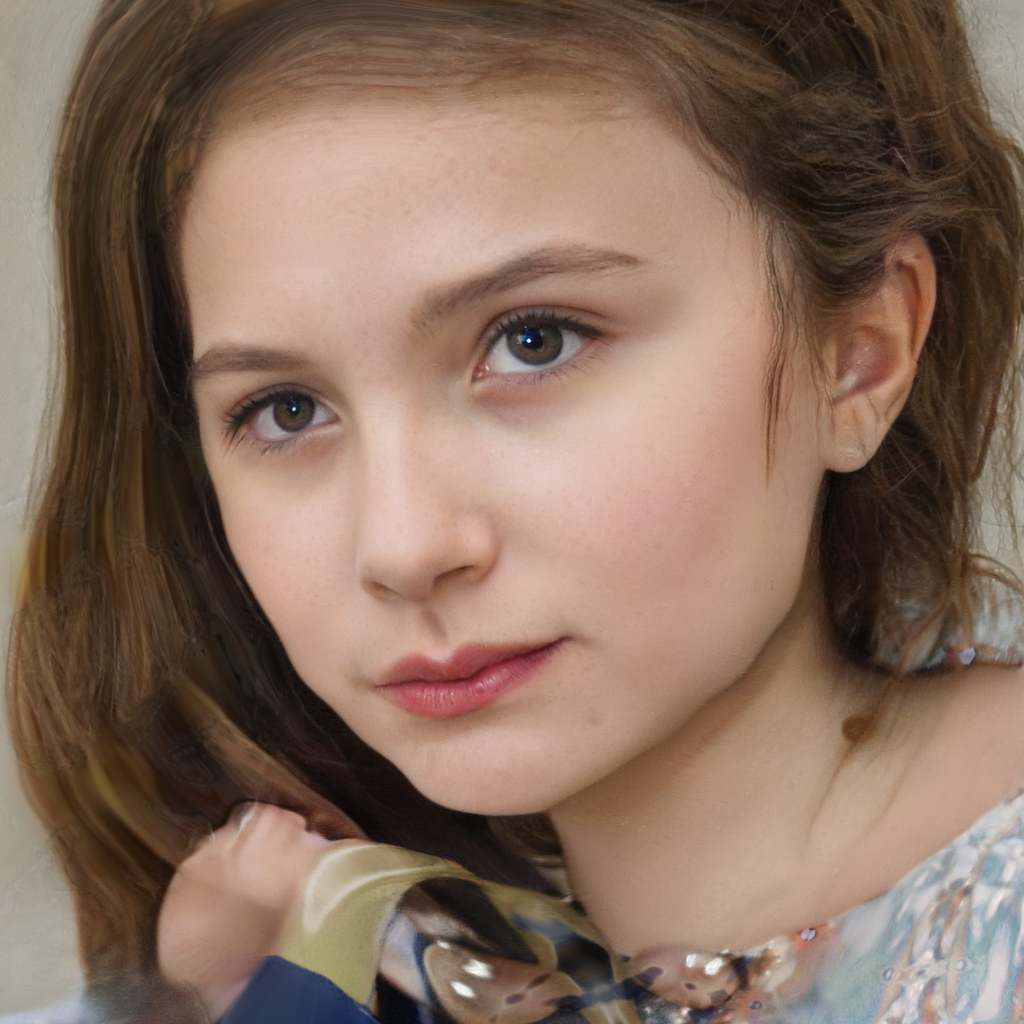

In [ ]:
%%time
b.generate(img)

In [ ]:
torch.save(a, '/notebooks/a.p')

In [ ]:
b = torch.load('/notebooks/a.p')

In [ ]:
%cd ./rewriting-activation-maps

/notebooks/rewriting-activation-maps


In [ ]:
from torchvision.transforms import ToTensor
from PIL import Image

from torch_utils.encoder_utils import combined_loss, ws_encoder_loss, loss_scheduler, compile_appended_network
from torch_utils.encoder_utils import show_maps, demo
from models.config import *

# from models.load_stylegan3_model import *

from tqdm.notebook import tqdm
from IPython.display import clear_output

from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from IPython import display

import torch




In [ ]:
# ffhq_256_AL6_bn16.p 
default_config = {
      'model': {
          'append_after':           6, 
          'nums_of_down_convs':     [1,1,2,2,1], #256 -> 128, 64, 32, 16, 16
          'nums_of_down_channels':  [128,256,512,1024,1024],
          'nums_of_up_convs':       [3,3,1], # 16 -> 32, 64, 128
          'nums_of_up_channels':    [1024,1024,1024],
          'kernal_sizes':           [3,3,1],
          'scale_factors':          [2,2,2],
          'sizes_of_blur':          [3,5,3],
          'bottleneck_size':        16,
          'num_of_linear_channels': [512,512],
          'in_size':                256
      },
      'optimizer': {
          'type': 'adamw',
          'lr': 0.00005,
          'betas': [0.95, 0.999],
          'eps': 1e-8,
          'weight_decay': 1e-3,
      },
      'loss_scheduler':{
          'mse_factor': [5,  3,  1, 0.5],
          'ws_factor':  [2.2,1,  1, 0.2],
          'milestones':  [0, 12, 17, 30]
      }
  }

In [ ]:

resume = '/notebooks/ffhq_256_AL6_bn16.p'
config = ''
batch_num = 16
ahead = 1
steps = 10
epoch = 400
seed = 100
truncation_psi = 1.0
clamp_up = 0
clamp_down = 0
g_pkl = './stylegan3-r-ffhqu-256x256.pkl'


device = torch.device('cuda')
config = default_config if default_config else load_config('')

if resume:
  from models.appended_encoder import AppendedEncoder
  appended_network = torch.load(resume)
  print(f'appended net resumed from {resume}')
else:
  model_config = config['model']
  appended_network = make_model(model_config,g_pkl)

z_dim = appended_network.z_dim
clamp = (clamp_down,clamp_up)

opt_config = config['optimizer']
optimizer_ahead = make_optimizer(opt_config, appended_network.parameters())
optimizer = make_optimizer(opt_config, appended_network.parameters())

loss_config = config['loss_scheduler']

p = compile_appended_network(appended_network,device)


appended net resumed from /notebooks/ffhq_256_AL6_bn16.p
preparing c++ plugins
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


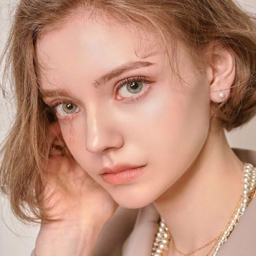

In [ ]:
img = Image.open('/notebooks/6.jpg').resize((256,256)).convert("RGB")
img

In [ ]:
%%time
p = appended_network.generate(img)

CPU times: user 71.8 ms, sys: 0 ns, total: 71.8 ms
Wall time: 27.7 ms


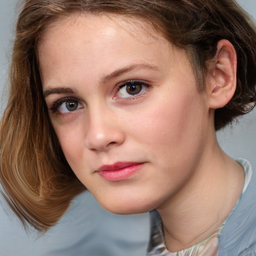

In [ ]:
p